In [41]:
#Base
import os
import numpy as np
import xarray as xr
import pandas as pd
from scipy import interpolate
import scipy.stats as st
from tqdm.notebook import trange, tqdm
from statsmodels.stats.multitest import fdrcorrection
import ray

#Plot
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import matplotlib.gridspec as gridspec

color_names=['amber','red','windows blue','faded green',
             'dusty purple',
             'orange',
             'steel blue',
             'pink',
             'greyish',
             'mint',
             'clay',
             'light cyan',
             'forest green',
             'pastel purple',
             'salmon',
             'dark brown',
             'lavender',
             'pale green',
             'dark red',
             'gold',
             'dark teal',
             'rust',
             'fuchsia',
             'pale orange',
             'cobalt blue',
             'mahogany',
             'cloudy blue',
             'dark pastel green',
             'dust',
             'electric lime',
             'fresh green',
             'light eggplant',
             'nasty green']
 
color_palette = sns.xkcd_palette(color_names)
cc = sns.xkcd_palette(color_names)

#V1DD
from allen_v1dd.client import OPhysClient, OPhysSession
from allen_v1dd.stimulus_analysis.correlation import calculate_correlation, ProgressBar
import allen_v1dd.stimulus_analysis.analysis_tools as at

%matplotlib inline
%load_ext autoreload
%autoreload 2

PlotDir = '/home/david.wyrick/projects/V1DD/plots'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
## Load data
base_folder = r"\\allen\programs\mindscope\workgroups\surround\v1dd_in_vivo_new_segmentation\data" #Server
base_folder = "/data/v1dd_in_vivo_new_segmentation" # Local on robinson for golden mouse
client = OPhysClient(base_folder)

##===== Load session from golden mouse =====##
mouse_id = 409828; col = 1; vol = 3; plane = 3

sess = client.load_ophys_session(mouse=mouse_id, column=col, volume=vol)
print(f"Loaded ophys session {sess.get_session_id()} (mouse {sess.get_mouse_id()}, column {sess.get_column_id()}, volume {sess.get_volume_id()})")


Loaded ophys session M409828_13 (mouse 409828, column 1, volume 3)


In [42]:
metrics_all = at.load_roi_metrics(metrics_file='~/Git/allen_v1dd/data_frames/v1dd_metrics.csv',add_columns=True, remove_invalid=False, remove_duplicates=False)

# Only consider valid metrics
n_before = len(metrics_all)
metrics_13 = metrics_all[metrics_all.is_valid & (metrics_all.mouse == 409828) & (metrics_all.column == 1) & (metrics_all.volume == 3)]
print(f"Only considering valid ROIs in M409828, col-1,vol-3: {len(metrics_13)} / {n_before} ({len(metrics_13)/n_before*100:.1f}%)")

metrics_13

Only considering valid ROIs in M409828, col-1,vol-3: 2708 / 52826 (5.1%)


,mouse,column,volume,plane,roi,is_valid,is_ignored_duplicate,has_duplicate,n_duplicates,duplicate_rois,...,spontaneous_event_mean,spontaneous_event_std,depth_chunk,depth_trunc,vol_plane,dgw_is_responsive,dgf_is_responsive,ssi_fit,dgw_pref_dir_fit,dgf_pref_dir_fit
M409828_13_1_0,409828,1,3,1,0,True,False,True,2,"M409828_13_1_0, M409828_13_2_214",...,0.000429,0.002773,4,200,3-1,False,False,0.175127,19.837932,348.091708
M409828_13_1_1,409828,1,3,1,1,True,False,True,2,"M409828_13_1_1, M409828_13_2_35",...,0.000567,0.003633,4,200,3-1,False,False,0.218124,0.948082,314.819042
M409828_13_1_2,409828,1,3,1,2,True,False,False,0,NaN,...,0.000964,0.005869,4,200,3-1,False,False,0.182812,295.150372,126.913790
M409828_13_1_3,409828,1,3,1,3,True,False,True,2,"M409828_13_1_3, M409828_13_2_65",...,0.000782,0.005164,4,200,3-1,False,False,0.125851,131.588545,71.779196
M409828_13_1_4,409828,1,3,1,4,True,False,False,0,NaN,...,0.000886,0.006152,4,200,3-1,False,False,0.032789,275.427907,232.816749
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
M409828_13_6_706,409828,1,3,6,706,True,False,False,0,NaN,...,0.000425,0.002841,5,300,3-6,True,False,0.362698,73.038353,98.387835
M409828_13_6_722,409828,1,3,6,722,True,False,False,0,NaN,...,0.000360,0.002641,5,300,3-6,True,False,0.524505,246.541605,56.632700
M409828_13_6_723,409828,1,3,6,723,True,False,False,0,NaN,...,0.000615,0.003767,5,300,3-6,False,False,0.044187,58.405604,18.263005
M409828_13_6_776,409828,1,3,6,776,True,False,False,0,NaN,...,0.000598,0.004100,5,300,3-6,False,False,0.061579,19.067217,69.325038


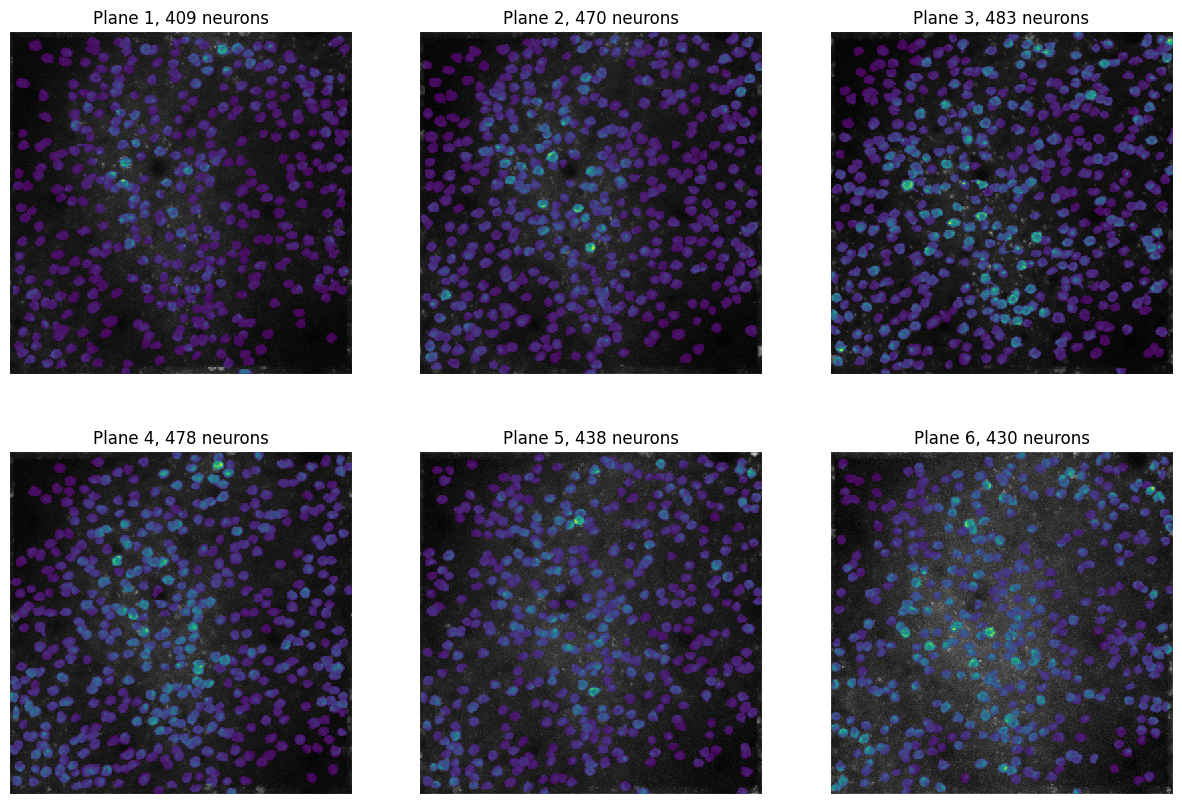

In [43]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15, 10))

## Load data from all planes
mask_list = []; neurons_list = []
for ii, plane in enumerate(sess.get_planes()):
    #Only take valid cells
    mask = sess.is_roi_valid(plane)
    indy = np.where(mask)[0]

    ##Get image
    proj_raw_mean, proj_raw_max, proj_de_mean, proj_de_max, proj_de_corr = sess.get_plane_projection_images(plane)

    roi_ids = np.array(sess.get_rois(plane))
    roi_ids_valid = roi_ids[indy]
    neurons_list.append(len(roi_ids_valid))
    # ##===== Plot where valid cells are in plane =====##
    mask = sess.get_roi_image_mask(plane, roi_ids_valid)
    mask_list.append(mask)
    ax = axes[ii//3,ii%3]; ax.axis('off')
    
    ax.imshow(proj_raw_max, cmap='gray', interpolation='nearest')
    ax.imshow(np.ma.masked_where(~mask,proj_de_max), cmap='viridis', interpolation='nearest')
    ax.set_title(f'Plane {plane}, {len(roi_ids_valid)} neurons')


In [45]:
np.sum(neurons_list)

2708

In [31]:
mask_list2 = []
for ii, mask in enumerate(mask_list):
    mask_list2.append(np.array(mask,dtype=int)*(ii+1))


In [32]:
mask_list2[0].shape

(512, 512)

<AxesSubplot: >

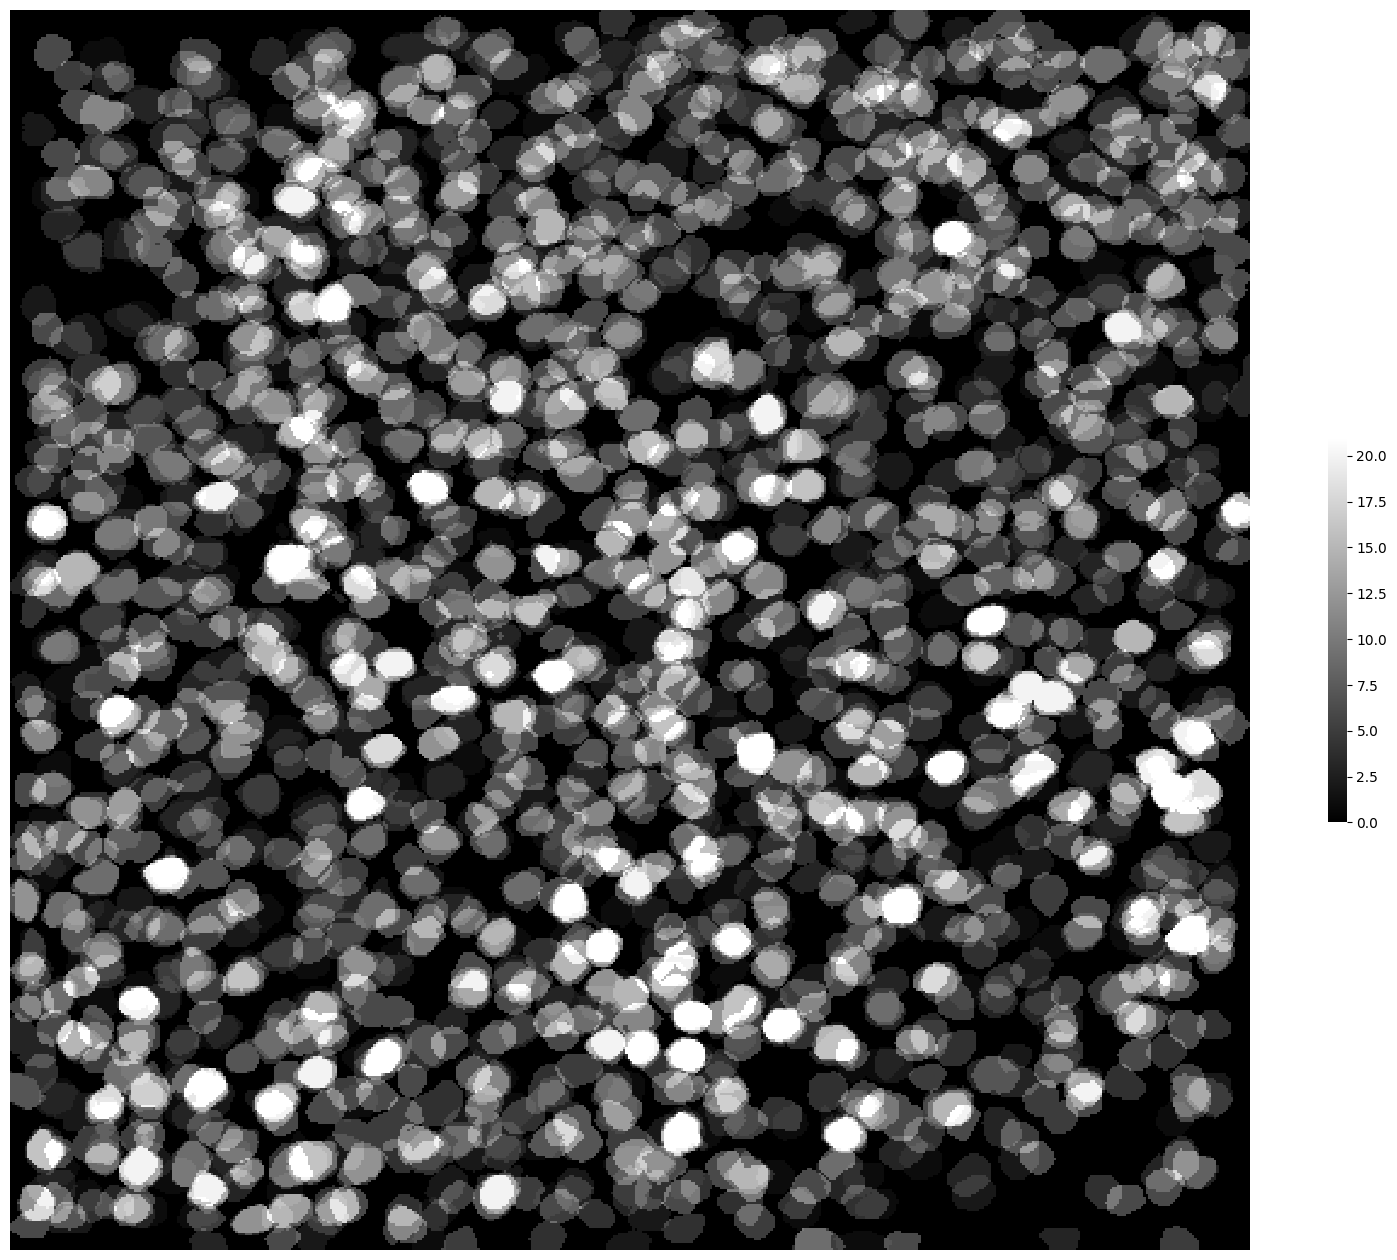

In [40]:
fig, ax = plt.subplots(figsize=(20,20))
ax.axis('off')
sns.heatmap(np.sum(mask_list2,axis=0),cmap='gray',cbar=True,square=True,cbar_kws={'shrink':0.25})


In [11]:
import pdb; pdb.pm()

> /home/david.wyrick/Git/allen_v1dd/david/h5py/h5o.pyx(190)h5py.h5o.open()

> /home/david.wyrick/Git/allen_v1dd/david/h5py/_objects.pyx(55)h5py._objects.with_phil.wrapper()

> /home/david.wyrick/Git/allen_v1dd/david/h5py/_objects.pyx(54)h5py._objects.with_phil.wrapper()

> /home/david.wyrick/anaconda3/envs/v1dd/lib/python3.10/site-packages/h5py/_hl/group.py(328)__getitem__()
    326                 raise ValueError("Invalid HDF5 object reference")
    327         elif isinstance(name, (bytes, str)):
--> 328             oid = h5o.open(self.id, self._e(name), lapl=self._lapl)
    329         else:
    330             raise TypeError("Accessing a group is done with bytes or str, "

> /home/david.wyrick/Git/allen_v1dd/david/h5py/_objects.pyx(55)h5py._objects.with_phil.wrapper()

> /home/david.wyrick/Git/allen_v1dd/david/h5py/_objects.pyx(54)h5py._objects.with_phil.wrapper()

> /home/david.wyrick/Git/allen_v1dd/src/allen_v1dd/client/ophys_session.py(441)get_roi_xy_pixels()
    439          

In [6]:
np.array(sess.get_rois(plane))[indy].shape

(409,)